Her bør vi rydde opp litt

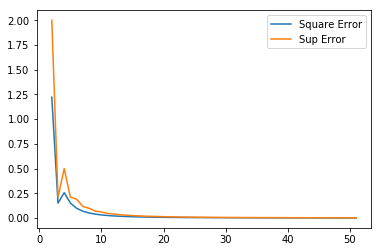

In [1]:
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import jacobian, grad
from functools import reduce, partial

class Point:
    __slots__ = ["x", "y"]

    def __init__(self, x = 0, y = 0):
        self.x = x
        self.y = y

    def __repr__(self):
        return "(x:" + str(self.x) + "; " + "y:" + str(self.y) + ")"

    def __setitem__(self, place, val):
        if place == "x" or place == 0:
            self.x = val
        if place == "y" or place == 1:
            self.y = val
        else:
            raise IndexError(f"{place} is out of range")

    def __getitem__(self, place):
        if place == "x" or place == 0:
            return self.x
        if place == "y" or place == 1:
            return self.y
        else:
            raise IndexError(f"{place} is out of range")

class Plottable():
    __slots__ = ["function", "max_dom", "min_dom"]

    def __init__(self, function = lambda x: 0, mi = 0, ma = 1):
        self.function, self.max_dom, self.min_dom = function, ma, mi
    
    def plot(self, start = None, end = None, step = 50):
        if start == None or end == None:
            xs = np.linspace(self.min_dom, self.max_dom, step)
            ys = list(map(self.function, xs))
        else:
            xs = np.linspace(start, end, step)
            ys = list(map(self.function, xs))
        plt.plot(xs, ys)

    def __call__(self, x):
        return self.function(x)


class Lagrange(Plottable):
    __slots__ = ["points"]

    #Merkelig nok virker denne dritten med autograd!
    def __init__(self, plist):
        self.points = plist
        xs, ys = self.sep()
        self.max_dom, self.min_dom = max(xs), min(xs)
        λj = lambda xj, ls, x: reduce(lambda a,b: a*b, map(partial(lambda y, yj, arg: (y-arg)/(yj-arg), x, xj), ls))
        self.function = lambda x: sum([ys[i]*partial(λj, xs[i], xs[0:i] + xs[i+1:len(xs)])(x) for i in range(len(xs))])

    def sep(self):
        return [p["x"] for p in self.points], [p["y"] for p in self.points] 

    def plot(self, step = 50):
        super().plot(self.min_dom, self.max_dom, step)

    #def __call__(self, x):
    #    return self.function(x)

class PiecewiseLagrange(Lagrange):
    __slots__ = ["functions", "interval"]

    def __init__(self, pinterval):
        self.points = pinterval
        self.functions = [Lagrange(plist) for plist in pinterval]
        self.interval = [(lambda x: (min(x), max(x)))(l.sep()[0]) for l in self.functions]
        self.function = lambda x: self.nfunction(x)
        self.min_dom, self.max_dom = self.interval[0][0], self.interval[-1][1]

    def sep(self):
        return [p.sep() for p in functions]

    def nfunction(self, x):
        if x < self.interval[0][1]:
            return self.functions[0](x)
        for i in range(1, len(self.interval)-1):
            (m, n) = self.interval[i]
            if m < x and x < n:
                return self.functions[i](x)
        return self.functions[-1](x)

    #def __call__(self, x):
    #    return self.function(x)

def equiNode(start, end, step, f = (lambda x: 0)):
    xs = np.linspace(start, end, step)
    ys = map(f, xs)
    return [Point(x,y) for (x,y) in zip(xs,ys)]

def chebyNode(start, end, steps, f = lambda x: 0):
    xs = [(end-start)/2*(np.cos(np.pi*(2*x+1)/(2*steps)))+(end+start)/2 for x in range(steps)]
    ys = map(f, xs)
    return [Point(x,y) for (x,y) in zip(xs, ys)]

def runge(x):
    return 1/(x**2+1)

class ErrorCompare(Plottable):
    __slots__ = ["sqErr", "supErr", "N"]

    def __init__(self, function, mi, ma, n = 10):
        super().__init__(function, mi, ma)
        #self.N = n
        #self.sqErr, self.supErr = [self.err2(m+1) for m in range(1, n)], [self.errSup(m+1) for m in range(1, n)]

    def genny(self, steps = None):
        return None

    def err2(self, n):
        p, f = [P["y"] for P in equiNode(self.min_dom, self.max_dom, 100*n, self.genny(steps = n).function)], [P["y"] for P in equiNode(self.min_dom, self.max_dom, 100*n, self.function)]
        return np.sqrt((self.max_dom-self.min_dom)/(100*n)*sum([(y-x)**2 for (x,y) in zip(p,f)]))

    def errSup(self, n):
        p, f = [P["y"] for P in equiNode(self.min_dom, self.max_dom, 100*n, self.genny(steps = n).function)], [P["y"] for P in equiNode(self.min_dom, self.max_dom, 100*n, self.function)]
        return max([abs(y-x) for (x,y) in zip(p,f)])
    
    def plot(self):
        plt.plot(range(2, self.N+1), self.sqErr, label = "Square Error")
        plt.plot(range(2, self.N+1), self.supErr, label = "Sup Error")
        plt.legend()


class ErrorLagrange(ErrorCompare):
    def __init__(self, function, mi, ma, n = 10):
        super().__init__(function, mi, ma, n)
        self.N = n
        self.sqErr, self.supErr = [self.err2(m+1) for m in range(1, n)], [self.errSup(m+1) for m in range(1, n)]

    def genny(self, steps = None, ver = "Equi"):
        if steps == None:
            steps = self.N
        if ver == "Equi":
            return Lagrange(equiNode(self.min_dom, self.max_dom, steps, self.function))
        if ver == "Cheby":
            return Lagrange(chebyNode(self.min_dom, self.max_dom, steps, self.function))
        return None

class ErrorPiecewiseLagrange(ErrorCompare):
    __slots__ = ["K"]

    def __init__(self, function, mi, ma, n = 10, k = 10):
        super().__init__(function, mi, ma)
        self.N, self.K = n, k
        self.sqErr, self.supErr = [self.err2(k+2) for k in range(self.K)], [self.errSup(k+2) for k in range(self.K)] 

    def genny(self, k):
        intervals = np.linspace(self.min_dom, self.max_dom, k)
        intervals = [(intervals[i], intervals[i+1]) for i in range(len(intervals)-1)]
        pintervals = [equiNode(mi, ma, self.N, self.function) for (mi, ma) in intervals]
        return PiecewiseLagrange(pintervals)

    def err2(self, n):
        p, f = [P["y"] for P in equiNode(self.min_dom, self.max_dom, 100*self.N, self.genny(n).function)], [P["y"] for P in equiNode(self.min_dom, self.max_dom, 100*self.N, self.function)]
        return np.sqrt((self.max_dom-self.min_dom)/(100*self.N)*sum([(y-x)**2 for (x,y) in zip(p,f)]))

    def errSup(self, n):
        p, f = [P["y"] for P in equiNode(self.min_dom, self.max_dom, 100*self.N, self.genny(n).function)], [P["y"] for P in equiNode(self.min_dom, self.max_dom, 100*self.N, self.function)]
        return max([abs(y-x) for (x,y) in zip(p,f)])

    def plot(self):
        plt.plot(range(2, self.K+2), self.sqErr, label = "Square Error")
        plt.plot(range(2, self.K+2), self.supErr, label = "Sup Error")
        plt.legend()


# This is supposed to be defined on [0,1]
def a(x):
    return np.cos(2*np.pi*x)

# This is supposed to be defined on [0,π/4]
def b(x):
    return np.exp(3*x)*np.sin(2*x)

"""
#Debug
d = PiecewiseLagrange([])
print(d.min_dom)
"""

"""
# Task i)
plt.figure()
r = Plottable(runge, -5, 5)
r.plot()
p = Lagrange(chebyNode(-5, 5, 10, runge))
p.plot()
plt.show()
"""

"""
# Task ii)
plt.figure()
u = ErrorLagrange(a, 0, 1, 50)
u.plot()
plt.show()

plt.figure()
u = ErrorLagrange(b, 0, np.pi/4, 50)
u.plot()
plt.show()
"""

# Task iii)
plt.figure()
u = ErrorPiecewiseLagrange(a, 0, 1, 2, 50)
u.plot()
plt.show()

# Gradient descent

In [10]:
import autograd.numpy as np
from autograd import grad

# f(x,y,z) = cos(x)+y^2
def f(args):
    return np.cos(args[0])+args[1]**2
    

def gradientDescent(F,x0,gamma,TOLx,TOLgrad,maxIter, h):
    gamma = 1
    gradF = grad(F)
    f = F(x0)
    x1 = x0
    
    for n in range(maxIter):
        x0 = x1
        g = gradF(x0)
        x1 = x0 - np.multiply(gamma,g)
        if F(x1) > F(x0) - gamma/2*np.linalg.norm(g,2)**2:
            gamma = h*gamma
        if (np.linalg.norm(x1-x0,2) <= TOLx) or (np.linalg.norm(gradF(x1),2) <= TOLgrad):
            break
    return x1

gradientDescent(f,np.array([4.0,20.0]),0.01,10e-10,10e-10,100, 0.5)

array([ 3.14159265e+00, -2.56327530e-24])